In [1]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

In [2]:
def process_etf_data(etf_files, trading_folder="~/Desktop/Trading"):
    # Define the Data folder path
    data_folder = os.path.join(os.path.expanduser(trading_folder), "Data")
    
    # Initialize an empty list to store the DataFrames
    data_frames = []
    
    # Iterate over the list of ETF files
    for file_name in etf_files:
        # Construct the full file path
        file_path = os.path.join(data_folder, file_name)
        
        # Read the CSV file into a DataFrame
        data = pd.read_csv(file_path)
        
        # Convert 'Date' column to datetime format (assuming the column is named 'Date' in each file)
        data['Date'] = pd.to_datetime(data['Date'])
        
        # Rename columns to include ETF name
        etf_name = file_name.split('_')[0]  # Assuming the format of file name is like "SPY_history.csv"
        data = data.add_suffix(f'_{etf_name}')
        
        # Append the DataFrame to the list
        data_frames.append(data)
    
    # Combine all DataFrames side by side
    combined_data = pd.concat(data_frames, axis=1)
    
    return combined_data

# Example usage
etf_files = ["SPY_history.csv", "XLU_history.csv", "XLF_history.csv"]
combined_data = process_etf_data(etf_files)


In [3]:
# Sort the DataFrame by date in ascending order
combined_data = combined_data.sort_values(by='Date_XLU', ascending=True)

In [4]:
# Assuming 'data' is your existing DataFrame
combined_data['Original_Index'] = combined_data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

combined_data.head(2)

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


,Date_SPY,Close/Last_SPY,Volume_SPY,Open_SPY,High_SPY,Low_SPY,Date_XLU,Close/Last_XLU,Volume_XLU,Open_XLU,High_XLU,Low_XLU,Date_XLF,Close/Last_XLF,Volume_XLF,Open_XLF,High_XLF,Low_XLF,Original_Index
2515,2015-01-26,205.45,91684840,204.71,205.56,203.85,2015-01-26,49.11,8129107,49.10,49.15,48.66,2015-01-26,19.5712,22410730,19.4360,19.5794,19.3910,2515
2514,2015-01-27,202.74,133590500,202.97,204.12,201.74,2015-01-27,49.18,8746036,48.99,49.44,48.89,2015-01-27,19.3582,28581910,19.3008,19.4893,19.2845,2514


In [5]:
combined_data.columns

Index(['Date_SPY', 'Close/Last_SPY', 'Volume_SPY', 'Open_SPY', 'High_SPY',
       'Low_SPY', 'Date_XLU', 'Close/Last_XLU', 'Volume_XLU', 'Open_XLU',
       'High_XLU', 'Low_XLU', 'Date_XLF', 'Close/Last_XLF', 'Volume_XLF',
       'Open_XLF', 'High_XLF', 'Low_XLF', 'Original_Index'],
      dtype='object')

In [11]:
# Select only the "Close/Last_" columns
close_columns = [col for col in combined_data.columns if col.startswith('Close/Last_')]

# Calculate daily percentage returns
returns = combined_data[close_columns].pct_change()

# Drop NaN values (from the first row caused by pct_change)
returns = returns.dropna()

# 1. Correlation Matrix
correlation_matrix = returns.corr()

# 2. Covariance Matrix
covariance_matrix = returns.cov()

# 3. Beta Matrix - Adjust to have the same shape as correlation and covariance matrices
benchmark = close_columns[0]
betas = {}

# Initialize beta_matrix with NaN values to match the size of the correlation and covariance matrices
beta_matrix = pd.DataFrame(np.nan, index=close_columns, columns=close_columns)

for col in close_columns:
    for row in close_columns:
        if col == row:
            beta_matrix.loc[row, col] = 1
        else:
            beta = covariance_matrix.loc[col, benchmark] / covariance_matrix.loc[benchmark, benchmark] 
            beta_matrix.loc[col, benchmark] = beta
            
# Now the beta_matrix has the correct values and shape


In [12]:
correlation_matrix.head(5)


,Close/Last_SPY,Close/Last_XLU,Close/Last_XLF
Close/Last_SPY,1.000000,0.567937,0.848155
Close/Last_XLU,0.567937,1.000000,0.485678
Close/Last_XLF,0.848155,0.485678,1.000000


In [13]:
covariance_matrix.head(5)

,Close/Last_SPY,Close/Last_XLU,Close/Last_XLF
Close/Last_SPY,0.000124,0.000077,0.000132
Close/Last_XLU,0.000077,0.000149,0.000083
Close/Last_XLF,0.000132,0.000083,0.000196


In [14]:
beta_matrix.head(5)

,Close/Last_SPY,Close/Last_XLU,Close/Last_XLF
Close/Last_SPY,1.000000,NaN,NaN
Close/Last_XLU,0.621921,1.0,NaN
Close/Last_XLF,1.066677,NaN,1.0


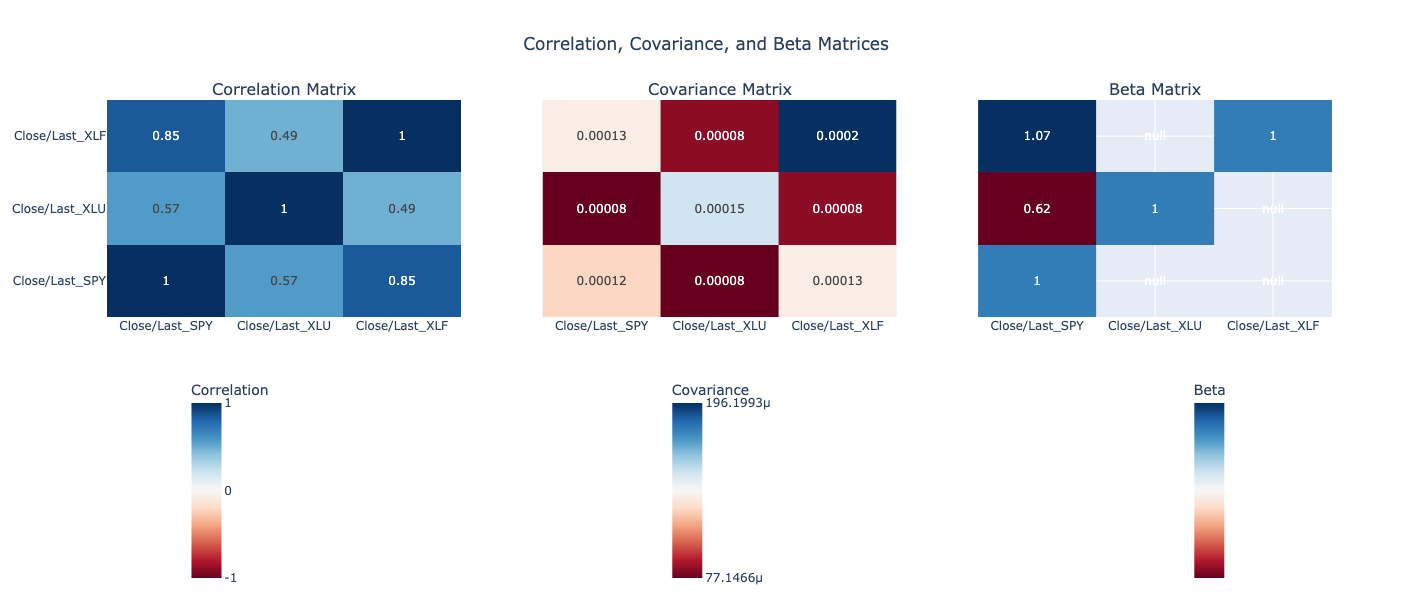

In [15]:
# Create subplots
fig = make_subplots(
    rows=1, cols=3,  # 1 row, 3 columns for each heatmap
    subplot_titles=("Correlation Matrix", "Covariance Matrix", "Beta Matrix"),
    column_widths=[0.33, 0.33, 0.33],  # Equal widths for all columns
    shared_yaxes=True,  # Share y-axis between plots
    shared_xaxes=True   # Share x-axis between plots
)

# Add Correlation Matrix
fig.add_trace(
    go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.columns,
        colorscale="RdBu",
        zmin=-1, zmax=1,  # Adjust range for correlation
        colorbar=dict(title="Correlation", tickvals=[-1, 0, 1], ticktext=["-1", "0", "1"], yanchor="top", y=-0.25, x=0.1, xanchor="center"),  # Adjust colorbar position
        text=correlation_matrix.values.round(2),  # Display rounded values inside cells
        texttemplate="%{text}",  # Ensure the text is displayed in cells
        showscale=True,
        hoverinfo="skip"  # Disable hover functionality
    ),
    row=1, col=1
)

# Add Covariance Matrix
fig.add_trace(
    go.Heatmap(
        z=covariance_matrix.values,
        x=covariance_matrix.columns,
        y=covariance_matrix.columns,
        colorscale="RdBu",
        colorbar=dict(title="Covariance", tickvals=[covariance_matrix.values.min(), 0, covariance_matrix.values.max()], yanchor="top", y=-0.25, x=0.5, xanchor="center"),  # Adjust colorbar position
        text=covariance_matrix.values.round(5),  # Display rounded values inside cells
        texttemplate="%{text}",  # Ensure the text is displayed in cells
        showscale=True,
        hoverinfo="skip"  # Disable hover functionality
    ),
    row=1, col=2
)

# Add Beta Matrix
fig.add_trace(
    go.Heatmap(
        z=beta_matrix.values,
        x=beta_matrix.columns,
        y=beta_matrix.columns,
        colorscale="RdBu",
        colorbar=dict(title="Beta", tickvals=[beta_matrix.values.min(), 0, beta_matrix.values.max()], yanchor="top", y=-0.25, x=0.9, xanchor="center"),  # Adjust colorbar position
        text=beta_matrix.values.round(2),  # Display rounded values inside cells
        texttemplate="%{text}",  # Ensure the text is displayed in cells
        showscale=True,
        hoverinfo="skip"  # Disable hover functionality
    ),
    row=1, col=3
)

# Update layout and title
fig.update_layout(
    title="Correlation, Covariance, and Beta Matrices",
    height=600,  # Adjust the height of the figure
    showlegend=False,
    title_x=0.5,  # Center the title
    coloraxis_showscale=False  # Disable the common color scale if needed
)

# Show the interactive heatmap
fig.show()
